In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from ulam import *

with UlamModel(stan_file=None) as u:
    # Should go to the data block
    N = u.data('N', u.integer(lower=0))
    x = u.data('x', u.vector(N))
    y = u.data('y', u.vector(N), predict=True)

    # Should go to the parameters block
    intercept = u.parameter('intercept', u.real())
    slope = u.parameter('slope', u.real())
    error = u.parameter('error', u.real(lower=0.01))

    # Should go to the generated quantities block
    log_lik = u.generated('log_lik', u.vector(N))
    # y__hat = u.generated('y__hat', u.vector(N))

    for i in u.range('i', 1, N, block='model'):
        y[i] ^ u.normal(x[i] * slope + intercept, error)

    for i in u.range('i', 1, N, block='generated'):
        log_lik[i] << u.normal_lpdf(y[i], x[i] * slope + intercept, error)
        y__hat[i] << u.normal_rng(x[i] * slope + intercept, error)

20:18:44 - cmdstanpy - INFO - compiling stan file /home/tmbb/Projects/sideprojects/python/ulam/ulam_models/ulam_model_ba994318a136952b4898f6b7f74ce611f8f35b92.stan to exe file /home/tmbb/Projects/sideprojects/python/ulam/ulam_models/ulam_model_ba994318a136952b4898f6b7f74ce611f8f35b92
20:19:04 - cmdstanpy - INFO - compiled model executable: /home/tmbb/Projects/sideprojects/python/ulam/ulam_models/ulam_model_ba994318a136952b4898f6b7f74ce611f8f35b92


In [3]:
from cmdstanpy import CmdStanModel
import numpy
import scipy.stats

slope = 0.89
intercept = -0.5
error = 0.3

N = 70
x = scipy.stats.norm.rvs(size=N, loc=2.5, scale=0.7)
y = scipy.stats.norm.rvs(size=N, loc=(x * slope + intercept), scale=error)
data = dict(N=N, x=x, y=y)

idata = u.sample(data=data)
idata

00:32:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:32:47 - cmdstanpy - INFO - CmdStan done processing.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

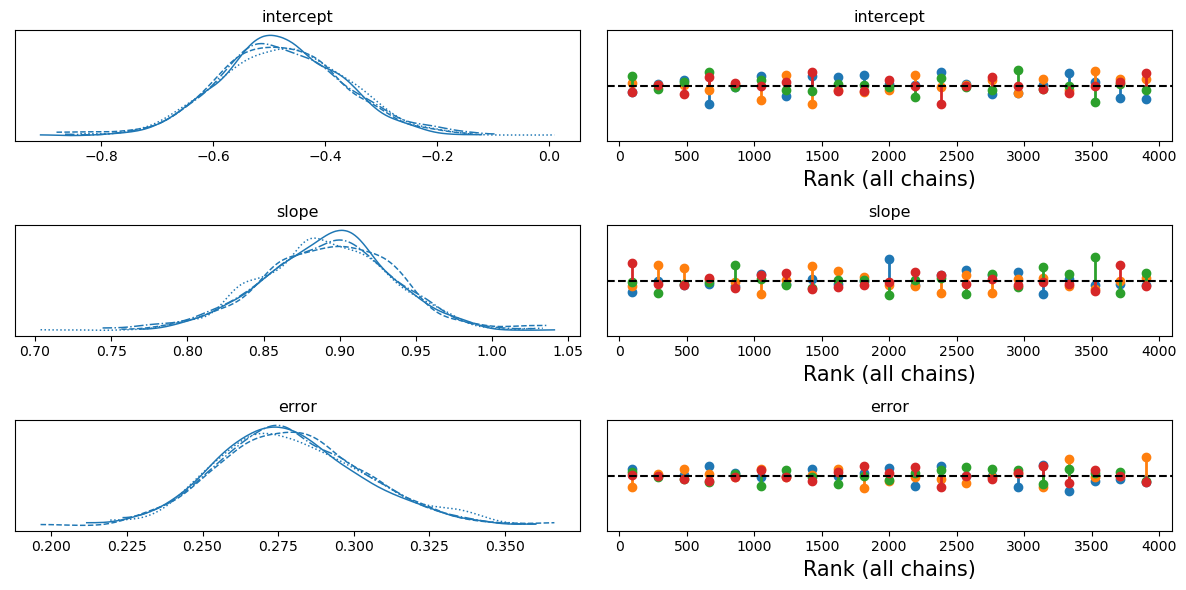

In [20]:
from matplotlib import pyplot

axes = arviz.plot_trace(idata, kind='rank_vlines')
fig = axes[0, 0].get_figure()
fig.tight_layout()

<AxesSubplot:xlabel='y / y__hat'>

/home/tmbb/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


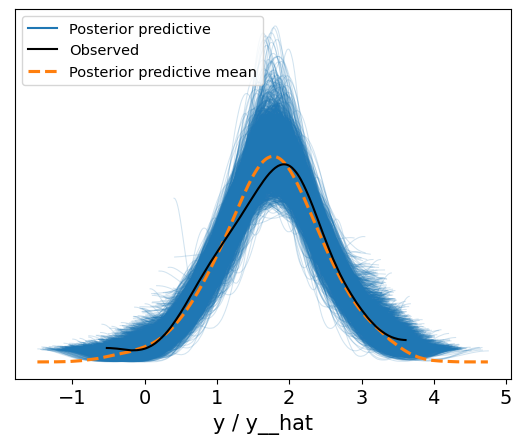

In [7]:
u.plot_ppc(idata)

In [5]:
import arviz

idata = arviz.from_cmdstanpy(
    posterior=fit,
    posterior_predictive='y_hat',
    observed_data={'y': y}
)

# arviz.plot_ppc(idata, data_pairs={'y': 'y_hat'}, kind='kde')
arviz.plot_loo_pit(idata=idata, y='y', y_hat='y_hat', ecdf=True)

NameError: name 'fit' is not defined

In [ ]:
import numpy
import pandas

def ith_element(i):
    if i % 4 == 1 or i % 7 == 2:
        return numpy.NaN
    else:
        return (i * i * 1.3 + 4.5) / (i - 0.8) 

s = pandas.Series([ith_element(i) for i in range(1, 30)])
s

class UlamSeries:

    def __init__(self, values):
        indices = list(range(0, len(values)))
        series = pandas.Series(values, index=indices)

        N = len(series)
        # Force conversion into 0 or 1
        is_missing = series.isna() + 0

        missing = series[series.isna()]
        not_missing = series[~series.isna()]
        index_for_datapoint = numpy.array([numpy.NaN for _i in range(1, N + 1)])

        for (i, index) in enumerate(missing.index):
            index_for_datapoint[index] = i
        
        for (i, index) in enumerate(not_missing.index):
            index_for_datapoint[index] = i

        # No NaN values remain in the array
        # TODO: should we test this at runtime?
        for value in index_for_datapoint:
            assert not pandas.isna(value)

        self.series = series
        self.N = len(series)
        self.is_missing = is_missing
        self.missing = missing.values
        self.N_missing = len(missing)
        self.not_missing = not_missing.values
        self.N_not_missing = len(not_missing)

    def __repr__(self):
        header = """
┌───────────────────────────┐
│ UlamSeries                │
├───────────────────────────┘
│ \
"""

        footer = """
└───────────────────────────
"""

        middle = "\n| ".join(repr(self.series).split("\n"))

        return header + middle + footer
    
UlamSeries(s)



┌───────────────────────────┐
│ UlamSeries                │
├───────────────────────────┘
│ 0           NaN
| 1           NaN
| 2      7.363636
| 3      7.906250
| 4           NaN
| 5      9.865385
| 6     11.000000
| 7     12.180556
| 8           NaN
| 9     14.619565
| 10    15.862745
| 11    17.116071
| 12          NaN
| 13    19.643939
| 14    20.915493
| 15          NaN
| 16          NaN
| 17    24.750000
| 18    26.032967
| 19    27.317708
| 20          NaN
| 21    29.891509
| 22          NaN
| 23    32.469828
| 24          NaN
| 25    35.051587
| 26    36.343511
| 27    37.636029
| 28          NaN
| dtype: float64
└───────────────────────────

In [ ]:
import os
import re
from typing import List
from dataclasses import dataclass

import jinja2

@dataclass
class StanFunction:
    name: str
    arguments: List[str]
    argument_types: List[str]
    return_type: str

def full_paths_in_dir(directory):
    return [os.path.join(directory, path) for path in os.listdir(directory)]


def rename_builtins(name):
    if name == 'lambda':
        return 'lambda_'
    else:
        return name


def extract_functions_from_page_text(text):
    function_tuples = re.findall(r'<!--\s*([^;]+)\s*;\s*([^;]+)\s*;\s*\(([^)]+)\);\s*-->', text)
    functions = []

    for function_tuple in function_tuples:
        (return_type, fun, args_text) = function_tuple
        
        typed_args = [a.strip().rsplit(' ', 1) for a in re.split(r"[,\|]", args_text)]

        if ['...'] not in typed_args and ['array['] not in typed_args and fun != 'map_rect':
            arg_types = [typed_arg[0] for typed_arg in typed_args]
            args = [typed_arg[1] for typed_arg in typed_args]
            args = [rename_builtins(arg) for arg in args]

            function = StanFunction(
                name=fun,
                arguments=args,
                argument_types=arg_types,
                return_type=return_type
            )

            functions.append(function)

    return functions
    


def extract_functions_from_page(path):
    with open(path) as f:
        contents = f.read()
    
    return extract_functions_from_page_text(contents)

pages = [path for path in full_paths_in_dir('stan-docs/functions-reference') if path.endswith('.Rmd')]

template = jinja2.Template("""
from py_expr import PyExpr, python_to_ast
from stan_ast import FunctionCall

class StanFunctionsLibrary:
    def _function(self, function_name, args):
        arguments_as_ast = [python_to_ast(arg) for arg in args]
        function_call_ast = FunctionCall(function_name, arguments_as_ast)
        self.functions[function_name] = self.functions.get(function_name, 0) + 1

        return PyExpr(self, function_call_ast)
              
{% for f in functions %}
    def {{ f.name }}({% for arg in ['self'] + f.arguments %}{{ arg }}{{ ", " if not loop.last else "" }}{% endfor %}):
        self._function('{{ f.name }}', [{% for arg in f.arguments %}{{ arg }}{{ ", " if not loop.last else "" }}{% endfor %}])          
{% endfor %}
""")

def maybe_add_sampling_distribution_for_function(functions, function):
    if function.name.endswith('_lpdf') or function.name.endswith('_lpmf'):
        if function.name.endswith('_lpdf'):
            suffix = '_lpdf'
        elif function.name.endswith('_lpmf'):
            suffix = '_lpmf'

        base_name = function.name[:-5]

        f_sampling = StanFunction(
            name=base_name,
            arguments=function.arguments[1:],
            argument_types=function.argument_types[1:],
            return_type=None
        )

        # Right censoring (for survival analysis)

        f_right_censored = StanFunction(
            name=base_name + "_with_right_censoring",
            arguments=function.arguments[1:],
            argument_types=function.argument_types[1:],
            return_type=None
        )

        f_right_censored_lpdf = StanFunction(
            name=base_name + "_with_right_censoring" + suffix,
            arguments=function.arguments + ['event'],
            argument_types=function.argument_types + ['reals'],
            return_type='reals'
        )
        
        f_right_censored_lupdf = StanFunction(
            name=base_name + "_with_right_censoring" + suffix,
            arguments=function.arguments + ['event'],
            argument_types=function.argument_types + ['reals'],
            return_type='reals'
        )

        f_right_censored_rng = StanFunction(
            name=base_name + "_with_right_censoring_rng",
            arguments=function.arguments + ['event'],
            argument_types=function.argument_types[1:] + ['reals'],
            return_type='reals'
        )

        # Left censoring (for survival analysis)
        
        f_left_censored = StanFunction(
            name=base_name + "_with_left_censoring",
            arguments=function.arguments[1:] + ['event'],
            argument_types=function.argument_types[1:] + ['reals'],
            return_type=None
        )

        f_left_censored_lpdf = StanFunction(
            name=base_name + "_with_left_censoring" + suffix,
            arguments=function.arguments + ['event'],
            argument_types=function.argument_types + ['reals', 'reals'],
            return_type='reals'
        )
        
        f_left_censored_lupdf = StanFunction(
            name=base_name + "_with_left_censoring" + suffix,
            arguments=function.arguments + ['event'],
            argument_types=function.argument_types + ['reals', 'reals'],
            return_type='reals'
        )

        f_left_censored_rng = StanFunction(
            name=base_name + "_with_left_censoring_rng",
            arguments=function.arguments + ['event'],
            argument_types=function.argument_types[1:] + ['reals'],
            return_type='reals'
        )
        # Right and left censoring (for survival analysis)
        
        f_left_and_right_censored = StanFunction(
            name=base_name + "_with_left_and_right_censoring",
            arguments=function.arguments[1:] + ['event_left', 'event_right'],
            argument_types=function.argument_types[1:] + ['reals', 'reals'],
            return_type=None
        )

        f_left_and_right_censored_lpdf = StanFunction(
            name=base_name + "_with_left_and_right_censoring" + suffix,
            arguments=function.arguments + ['event_left', 'event_right'],
            argument_types=function.argument_types + ['reals', 'reals'],
            return_type='reals'
        )
        
        f_left_and_right_censored_lupdf = StanFunction(
            name=base_name + "_with_left_and_right_censoring" + suffix,
            arguments=function.arguments + ['event_left', 'event_right'],
            argument_types=function.argument_types + ['reals', 'reals'],
            return_type='reals'
        )

        f_left_and_right_censored_rng = StanFunction(
            name=base_name + "_with_left_and_right_censoring_rng",
            arguments=function.arguments[1:] + ['event_left', 'event_right'],
            argument_types=function.argument_types[1:] + ['reals', 'reals'],
            return_type='reals'
        )

        new_functions = [
            function, f_sampling,
            f_left_censored, f_left_censored_lpdf, f_left_censored_lupdf, f_left_censored_rng,
            f_right_censored, f_right_censored_lpdf, f_right_censored_lupdf, f_right_censored_rng,
            f_left_and_right_censored, f_left_and_right_censored_lpdf, f_left_and_right_censored_lupdf,
            f_left_and_right_censored_rng
        ]

        functions.extend(new_functions)

    else:
        functions.append(function)

all_functions = []
for page in pages:
    functions = extract_functions_from_page(page)
    all_functions.extend(functions)

all_functions = [function for function in all_functions if not function.name.startswith('operator')]

functions = []
for function in all_functions:
    maybe_add_sampling_distribution_for_function(functions, function)

function_dict = dict()
for function in functions:
    if function.name in function_dict:
        pass
    else:
        function_dict[function.name] = function

functions = sorted(function_dict.values(), key=lambda f: f.name.lower())

open('stan_functions_library.py', 'w').write(template.render(functions=functions))

171692

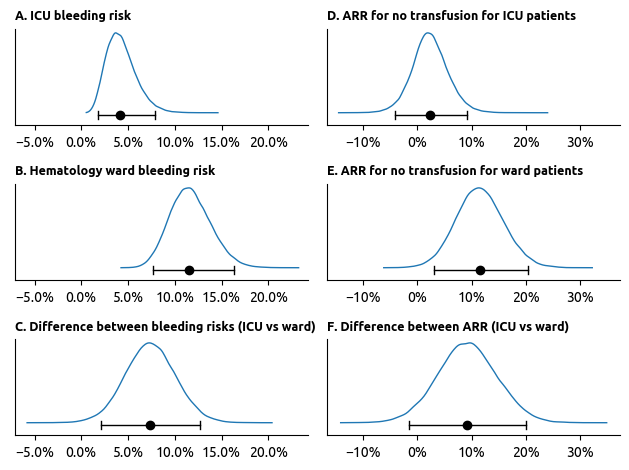

In [23]:
from scipy.stats import beta, gaussian_kde
import numpy

from matplotlib import pyplot
import matplotlib.ticker as mtick
import matplotlib
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)


def nejm_mpl_context():
    return matplotlib.rc_context({
        'font.family': 'Ubuntu',
        'lines.linewidth': 1,
        'font.size': 10,
        'axes.titlesize': 10
    })

N_SAMPLES = 4096 * 16

def sample_proportion(success, total, n=N_SAMPLES):
    return beta.rvs(success + 1, total - success + 1, size=n)

def sample_difference_of_proportions(success_a, total_a, success_b, total_b, n=N_SAMPLES):
    p1 = sample_proportion(success_a, total_a, n=n)
    p2 = sample_proportion(success_b, total_b, n=n)
    return p2 - p1

def share_x_axes(axs):
    if axs:
        ax0 = axs[0]
        other_axs = axs[1:]
        (min_x, max_x) = ax0.get_xlim()
        for ax in other_axs:
            (x_lower, x_upper) = ax.get_xlim()
            min_x = min(min_x, x_lower)
            max_x = max(max_x, x_upper)

        for ax in axs:
            ax.set_xlim(min_x, max_x)


def plot_dist(samples, ax=None, percent=95, lower_quantile=0.025, upper_quantile=0.975):
    prob = percent / 100
    lower_quantile = (1 - prob) * 0.5
    upper_quantile = 1 - ((1 - prob) * 0.5)

    if ax is None:
        (fig, ax) = pyplot.subplots(1)
    else:
        (fig, ax) = (None, ax)

    (ci_lower, ci_median, ci_upper) = numpy.quantile(
        samples,
        [lower_quantile, 0.5, upper_quantile]
    )

    
    density = gaussian_kde(samples)
    x = numpy.linspace(numpy.min(samples), numpy.max(samples), 250)
    y = density(x)
    bottom = -0.16 * numpy.max(y)

    ci_y = 0.2 * bottom
    dy = 0.3 * bottom

    ax.plot(x, y)
    
    ax.plot([ci_lower, ci_upper], [ci_y, ci_y], color='black')
    ax.plot([ci_lower, ci_lower], [ci_y - dy, ci_y + dy], color='black')
    ax.plot([ci_upper, ci_upper], [ci_y - dy, ci_y + dy], color='black')
    ax.scatter([ci_median], [ci_y], color='black')

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.spines[['top', 'right']].set_visible(False)

    ax.set_yticks([])
    ax.set_ylim(bottom)

def set_title(ax, title):
    ax.set_title(title, loc='left', fontweight='bold', fontsize=9, fontfamily='Ubuntu')

delta_p = sample_difference_of_proportions(9, 188, 22, 185)

bleeding_risk_ICU = sample_proportion(2 + 4, 80 + 81)
bleeding_risk_hematology_ward = sample_proportion(6 + 18, 108 + 104)
delta_bleeding_risk_by_setting = bleeding_risk_hematology_ward - bleeding_risk_ICU

delta_absolute_risk_ICU = sample_proportion(4, 81) - sample_proportion(2, 80)
delta_absolute_risk_hematology_ward = sample_proportion(18, 104) - sample_proportion(6, 108)
delta_delta_absolute_risks = delta_absolute_risk_hematology_ward - delta_absolute_risk_ICU

with nejm_mpl_context():
    (fig, [
        [ax_ICU, ax_arr_ICU],
        [ax_heme, ax_arr_heme],
        [ax_delta, ax_delta_arr]
        ]) = pyplot.subplots(3, 2)

    plot_dist(bleeding_risk_ICU, ax=ax_ICU)
    plot_dist(bleeding_risk_hematology_ward, ax=ax_heme)
    plot_dist(delta_bleeding_risk_by_setting, ax=ax_delta)

    set_title(ax_ICU, "A. ICU bleeding risk")
    set_title(ax_heme, "B. Hematology ward bleeding risk")
    set_title(ax_delta, "C. Difference between bleeding risks (ICU vs ward)")

    plot_dist(delta_absolute_risk_ICU, ax=ax_arr_ICU)
    plot_dist(delta_absolute_risk_hematology_ward, ax=ax_arr_heme)
    plot_dist(delta_delta_absolute_risks, ax=ax_delta_arr)


    set_title(ax_arr_ICU, "D. ARR for no transfusion for ICU patients")
    set_title(ax_arr_heme, "E. ARR for no transfusion for ward patients")
    set_title(ax_delta_arr, "F. Difference between ARR (ICU vs ward)")

    share_x_axes([ax_ICU, ax_heme, ax_delta])
    share_x_axes([ax_arr_ICU, ax_arr_heme, ax_delta_arr])
    fig.tight_layout()
